In [20]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy as scp
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
sns.set_style('whitegrid')

Считаем датасет из файла и избавимся от строчек с пропусками

In [24]:
data = pd.read_csv('flights_NY.csv')
data = data.dropna()

$1.$ По каждой авиакомпании оцените вероятность того, что задержка прилета будет положительной и нарисуйте график, показывающий распределение этой вероятности по авиакомпаниям.

Оценим вероятность, как отношение числа рейсов, для которых задержка положительна, к общему числу, сгруппировав по авиакомпании

In [3]:
pos_del_prob = (data[data['arr_delay'] > 0].groupby('carrier')['arr_delay'].count()/data.groupby('carrier')['arr_delay'].count()).rename('arr_delay_prob')
pos_del_prob

carrier
9E    0.383775
AA    0.335118
AS    0.266573
B6    0.436807
DL    0.344391
EV    0.479064
F9    0.575624
FL    0.596850
HA    0.283626
MQ    0.467029
OO    0.344828
UA    0.384583
US    0.370581
VX    0.341282
WN    0.440385
YV    0.474265
Name: arr_delay_prob, dtype: float64

Отразим результаты на графике

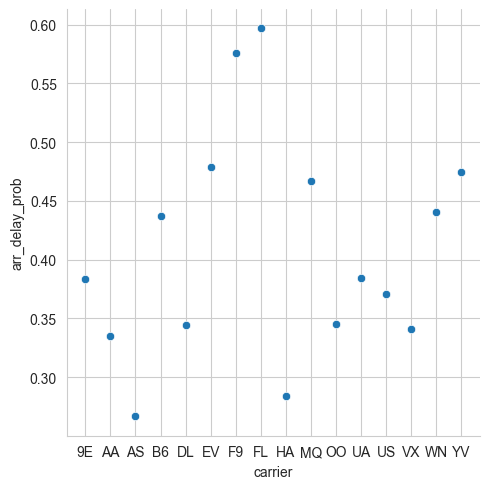

In [4]:
sns.relplot(data = pos_del_prob)

$2.$ Постройте гистограмму расстояния перелета distance. Выделите на ней три группы перелетов: короткие, средние и длинные. Какие значения distance разумно выбрать в качестве границы, разделяющей короткие. средние и длинные перелеты? Куда летят самолеты в группе длинных перелетов? Найдите среднее время задержки вылета в каждой из трех выделенных групп. 


Строим гистограмму. На ней явно выделяются три группы, конкретные границы которых затем выбираются "на глаз"

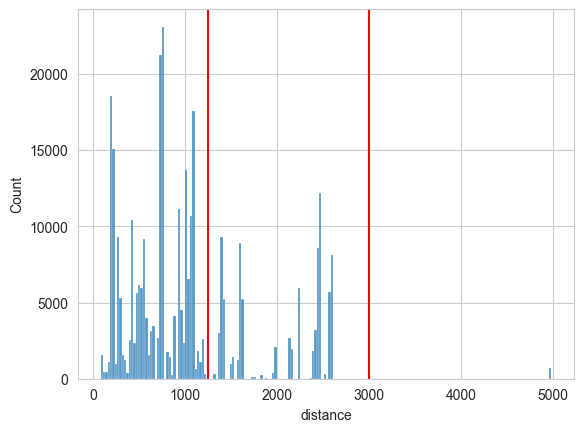

In [5]:
sns.histplot(data, x = 'distance')
plt.axvline(1250, 0, 5100, color = 'red')
plt.axvline(3000, 0, 5100, color = 'red')

Сформируем столбец, содержащий информацию о группе по дальности перелёта

In [6]:
def dist_group(x: float):
    if x < 1250:
        return 'Short'
    elif x < 3000:
        return 'Medium'
    else:
        return 'Long'
    
data['dist_group'] = data['distance'].apply(dist_group)

Определим, какие пункты назначения есть в группе длинных перелётов

In [7]:
data[data['dist_group'] == 'Long']['dest'].unique()

array(['HNL', 'ANC'], dtype=object)

Наконец, найдём среднюю задержку прибытия в каждой группе

In [ ]:
data.groupby('dist_group')['dep_delay'].mean()

dist_group
Long       9.355430
Medium    11.087874
Short     13.115219
Name: dep_delay, dtype: float64

$3.$ Нарисуйте график среднего времени задержки вылета по месяцам и отметьте на нем границы доверительных интервалов с уровнем доверия 0.95. С помощью подходящего статистического теста проверьте, можно ли принять гипотезу о равенстве средних в январе и феврале на уровне значимости 0.05? на уровне значимости 0.01? 

Построим график с помощью функции из пакета seaborn, которая как раз аггрегирует данные в каждой группе в среднее и отражает доверительный интервал bootstrap - распределения с уровнем доверия 0.95. Bootstrap кажется наиболее разумным, так как мы не знаем из какого распределения пришла выборка

<AxesSubplot: xlabel='month', ylabel='dep_delay'>

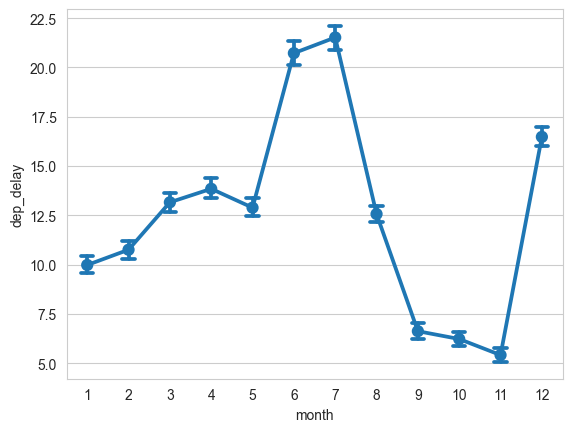

In [9]:
sns.pointplot(data, x = 'month', y = 'dep_delay', capsize= 0.3)

Используя t-test для независимых выборок, проверим гипотезу о равенстве средних в январе и феврале

In [ ]:
scp.stats.ttest_ind(data.groupby('month').get_group(1)['dep_delay'], data.groupby('month').get_group(2)['dep_delay'])

TtestResult(statistic=-2.386498623322741, pvalue=0.017013366495100532, df=50007.0)

Как можно видеть, гипотеза принимается на уровне значимости 0.01 и отвергается на 0.05

$4.$ Найдите коэффициент корреляции между расстоянием distance и временем полета air_time. Постройте точечную диаграмму в осях distance (х) и air_time (y). Найдите коэффициенты линейной регрессии и нанесите полученную прямую на график. Как можно интерпретировать смысл коэффициентов полученной линейной модели?

Найдём коэффициент корреляции

In [11]:
data['distance'].corr(data['air_time'])

0.9906496472248582

Найдём коэффициенты линейной регрессии

In [ ]:
regr = scp.stats.linregress(x = data['distance'], y = data['air_time'])
display(regr.slope, regr.intercept)

0.12611932467386067

18.466578127760357

Отразим результаты на графике

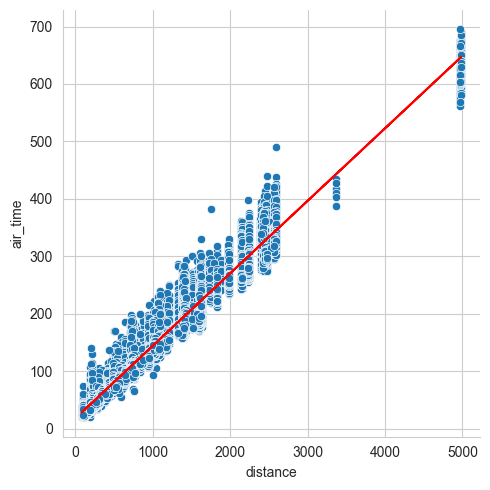

In [13]:
sns.relplot(data, x = 'distance', y = 'air_time')
plt.plot(data['distance'], data['distance'] * regr.slope + regr.intercept, color = 'red')

Наблюдаем высокую корреляцию, что естественно, так как пассажирские самолёты летят примерно с одной и той же скоростью. Угловой коэффициент линейной регрессии, собственно, и имеет смысл обратного значения средней скорости самолётов. Свободный член может отвечать, например, за время взлёта и посадки

$5.$ Постройте нормированную гистограмму распределения задержки прилета по тем рейсам, которые вылетели в пределах +/-15 минут от времени в расписании. Сделайте предположение о том, каким распределением может описываться полученная гистограмма, оцените параметры этого распределения и нанесите график плотности на график с гистограммой. Вопрос со звездочкой (необязательный): с помощью подходящего статистического теста проверьте, можно ли принять гипотезу о выбранном распределении?


Строим гистограмму

<AxesSubplot: xlabel='arr_delay', ylabel='Probability'>

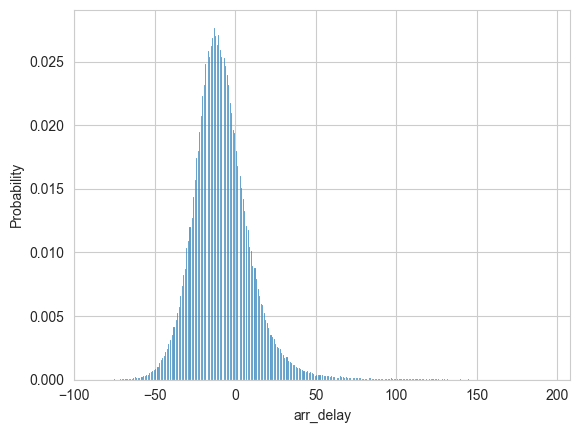

In [14]:
sns.histplot(data[np.abs(data['dep_delay']) < 15]['arr_delay'], stat = 'probability')

Выдвигаем гипотезу, что гистограмма соответствует нормальному распределению. Оцениваем параметры и строим соответствующий график

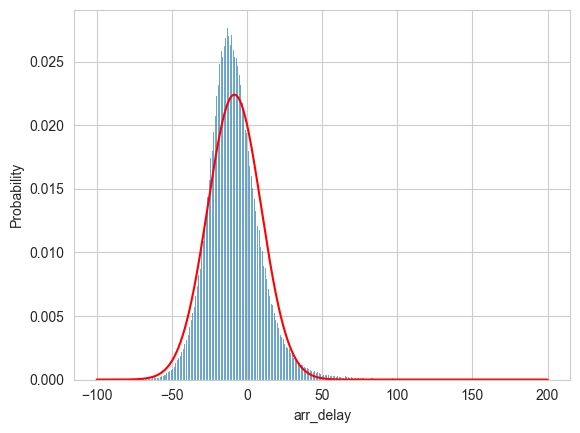

In [15]:
sigma = data[np.abs(data['dep_delay']) < 15]['arr_delay'].std()
mu = data[np.abs(data['dep_delay']) < 15]['arr_delay'].mean()

sns.histplot(data[np.abs(data['dep_delay']) < 15]['arr_delay'], stat = 'probability')
x = np.linspace(-100, 200, 1000)
plt.plot(x, scp.stats.norm.pdf(x, loc = mu, scale = sigma), color = 'red')

С помощью теста Колмогорова-Смирнова проверяем гипотезу

In [16]:
scp.stats.kstest(data[np.abs(data['dep_delay']) < 15]['arr_delay'], scp.stats.norm.cdf, args = [mu, sigma])

KstestResult(statistic=0.06330074743655989, pvalue=0.0, statistic_location=-3.0, statistic_sign=1)

Согласно тесту гипотезу следует отвергнуть

$6.$ Постройте модель логистической регрессии, которая будет предсказывать, что задержка прилета составит более 15 минут. Какие признаки вы будете использовать? Какие новые признаки, на основе имеющихся, можете предложить? Какова точность полученной модели (precision, recall, accuracy)? Вопрос со звездочкой (необязательный): изучите случаи, на которых модель ошибается – с чем связаны ошибки и как можно улучшить модель?

Исследуем возможные признаки. Наиболее естественными кажутся задержка вылета и время в пути. Проведём классификацию вручную и сравним со значениями признаков

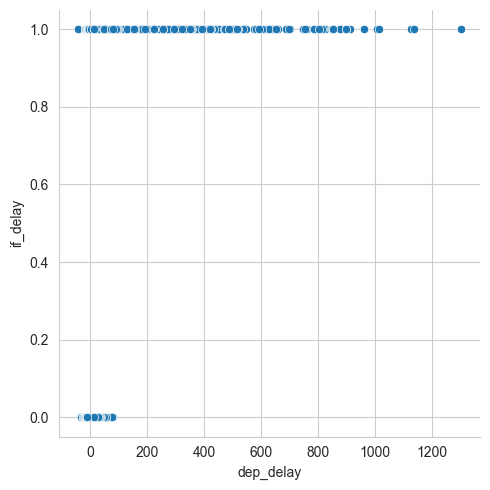

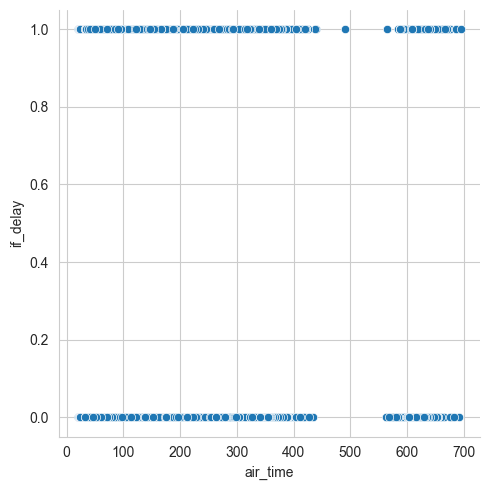

In [46]:
data['if_delay'] = data['arr_delay'] > 15

sns.relplot(data, x = 'dep_delay', y = 'if_delay')
sns.relplot(data, x = 'air_time', y = 'if_delay')

Видно, что с задержкой вылета корреляция явная, а со временем полёта она отсутствует. Таким образом будем использовать в качестве признака задержку вылета

Тренируем модель, используя кросс-валидацию, после чего отражаем результаты её обучения и применения на графике

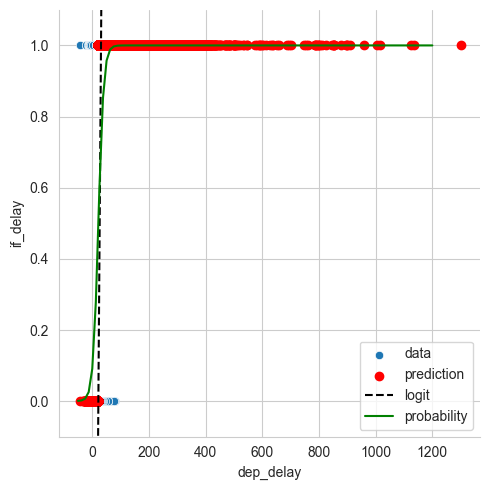

In [18]:
model = LogisticRegressionCV().fit(X = data[['dep_delay']].to_numpy().reshape(-1,1), y = data['if_delay'].to_numpy())
sns.relplot(data, x= data['dep_delay'], y = data['if_delay'], label= 'data')
plt.scatter(data['dep_delay'], model.predict(data[['dep_delay']].to_numpy().reshape(-1,1)), color = 'red', label = 'prediction')
plt.plot(np.linspace(-50, 1200, 100), model.coef_[0,0] *np.linspace(-50, 1200, 100)+model.intercept_[0],'--k', label = 'logit')
plt.plot(np.linspace(-50, 1200, 100), 1/(1+np.exp(-model.coef_[0,0] *np.linspace(-50, 1200, 100)-model.intercept_[0])), color = 'green', label = 'probability')
plt.ylim((-0.1, 1.1))
plt.legend()

Приводим количественные характеристики точности

In [23]:
print(classification_report(data['if_delay'], model.predict(data['dep_delay'].to_numpy().reshape(-1,1))))

              precision    recall  f1-score   support

       False       0.91      0.97      0.94    249716
        True       0.88      0.67      0.76     77630

    accuracy                           0.90    327346
   macro avg       0.89      0.82      0.85    327346
weighted avg       0.90      0.90      0.89    327346

